# Filtr Kalmana

Na podstawie <https://www.kalmanfilter.net/>

## Wprowadzenie i podstawowe pojęcia

**Średnia** (*mean*) - średnia wartość obliczona na podstawie znanego stanu **całej** populacji

$$ V_{mean} = \frac{1}{N}\sum^{N}_{n=1}V_n $$

In [1]:
import numpy as np

coin_values = np.array([5, 5, 10, 10, 10])
mean = np.mean(coin_values)

print(f"Wartości: {coin_values}")
print(f"Średnia: {mean}")

Wartości: [ 5  5 10 10 10]
Średnia: 8.0


**Wartość oczekiwana** (*expected value*) - wartość określająca spodziewany wynik ukrytej zmiennej

$$ W = \frac{1}{N}\sum^{N}_{n=1}W_n $$

In [2]:
generator = np.random.default_rng()

random_values = np.array(generator.normal(loc=80.0, scale=0.5, size=5))
expected_value = np.mean(random_values)

print(f"Losowe wartości: {random_values}")
print(f"Wartość oczekiwana: {expected_value}")

Losowe wartości: [80.24898079 80.178971   79.92640096 79.93109367 80.13316561]
Wartość oczekiwana: 80.08372240328217


**Wariancja** (*variance*) - miara rozrzutu wartości zbioru od jego średniej

$$ \sigma^2 = \frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2 $$

In [3]:
# zakładamy że jest to cała populacja
values = np.array(generator.normal(loc=1.9, scale=0.2, size=5))
mean = np.mean(values)
variance = np.var(values)

print(f"Wartości: {values}")
print(f"Średnia: {mean}")
print(f"Wariancja: {variance}")

Wartości: [1.49033381 2.0842751  2.24175656 1.77336786 1.71447981]
Średnia: 1.8608426279412313
Wariancja: 0.07227363647772106


**Odchylenie standardowe** (*standard deviation*) - pierwiastek kwadratowy wariancji 

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2} $$

In [4]:
std_deviation = np.std(values)
print(f"Odchylenie standardowe: {std_deviation}")

Odchylenie standardowe: 0.26883756522800356


Podczas **estymacji** wariancji i odchylenia standardowego z **części populacji** należy zastosować dzielnik $\frac{1}{N-1}$ zamiast $\frac{1}{N}$ (Poprawka Bessela)

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N - 1} \sum^{N}_{n=1}(x_n - \mu)^2} $$

### Rozkład normalny (*normal distribution*)

Rozkład normalny (rozkład Gaussa) to krzywa dzwonowa opisana następującym wzorem:

$$ f(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} $$


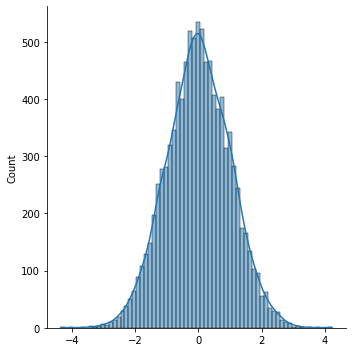

In [5]:
import seaborn as sns

values = generator.normal(loc=0.0, scale=1.0, size=10000)
sns.displot(values, kde=True)

### Estymacja, dokładność i precyzja

**Estymacja** (oszacowanie) polega na ocenie ukrytego stanu danego systemu. Przykładem może być pozycja samolotu - nie znamy dokładnej pozycji, ale możemy ją estymować za pomocą odpowiednich czujników, takich jak radar. W przypadku pojazdów naziemnych, możemy estymować pozycję na podstawie odometrów (na przykład enkoderów) lub czujników inercyjnych.

Estymacja może być znacznie poprawiona poprzez użycie różnych źródeł danych i aplikację filtrów oraz algorytmów pomagających w śledzeniu (takich jak filtr Kalmana). Każda wartość którą obliczymy na podstawie takich obserwacji jest estymatą.

**Dokładność** (*accuracy*) określa jak blisko prawdziwej wartości jest wartość zmierzona.
**Precyzja** (*precision*) określa jak bardzo różnią się od siebie wartości zmierzone dla tej samej wartości parametru (jak szeroko są rozsiane, jak duże jest ich odchylenie standardowe).

Systemy o wysokiej precyzji mają niską wariancję pomiarów, a systemy o niskiej precyzji - wysoką. Wariancja jest efektem losowego błędu pomiarowego.

Systemy o niskiej dokładności wprowadzają systematyczne przekłamanie (*bias*), które można stosunkowo łatwo wyeliminować poprzez odjęcie go od pomiarów, jeśli wiemy ile wynosi. Jeśli nie wiemy, lub nie możemy tego sprawdzić, nie ma innej możliwości na skompensowanie tego błędu.

Niską precyzję można skompensować poprzez uśrednianie zmierzonych wartości.

## Filtr alfa-beta-gamma

### Przykład 1 - pomiar wagi sztabek złota

Sztabka złota to system statyczny - nie zmienia swojego stanu w czasie w którym go rozpatrujemy.
Do pomiaru wagi użyjemy wagi z zerowym przekłamaniem (*biasem*), ale każdy pomiar będzie obarczony pewnym błędem.

Żeby estymować stan systemu (wagę sztabki), możemy wykonać kilka pomiarów i je uśrednić

W momencie $n$, estymata $\hat{x}_{n,n}$ będzie średnią wszystkich poprzednich pomiarów:

$$ \hat{x}_{n,n} = \frac{1}{n}(z_1 + z_2 + ... + z_{n-1} + z_n) = \frac{1}{n}\sum^{n}_{i=1}(z_i) $$

gdzie:

* $x$ to prawdziwa wartość wagi (której nie znamy, a którą estymujemy)
* $z_n$ to pomiar wartości w momencie $n$
* $\hat{x}_{n,n}$ to estymata $x$ w momencie $n$ (po wykonaniu pomiaru $z_n$)
* $\hat{x}_{n,n-1}$ to poprzednia estymata $x$ w momencie $n-1$ (po wykonaniu pomiaru $z_{n-1}$)
* $\hat{x}_{n+1,n}$ to estymata **przyszłego** stanu $(n+1)$ zmiennej $x$. Estymata ta jest obliczona w momencie $n$ (po wykonaniu pomiaru $z_n$). Innymi słowy, jest to przewidywany stan systemu.

W tym przypadku, dynamiczny model systemu jest stały, więc $\hat{x}_{n+1,n} = \hat{x}_{n,n}$

Powyższy wzór nie jest optymalny dla naszych zastosowań, ponieważ wymaga on trzymania wszystkich zmierzonych wartości w pamięci i obliczania wszystkich poprzednich stanów w celu estymacji kolejnego. Możemy nieco zmodyfikować ten wzór do poniższej postaci (pełny dowód przedstawiony jest tutaj: <https://www.kalmanfilter.net/alphabeta.html>)

$$ \hat{x}_{n,n} = \frac{1}{n}\sum^{n}_{i=1}(z_i) = \hat{x}_{n-1,n-1} + \frac{1}{n}(z_n - \hat{x}_{n-1,n-1}) $$

gdzie $\hat{x}_{n-1,n-1}$ jest estymowanym stanem zmiennej $x$ w momencie $n-1$, obliczonym na podstawie pomiaru wykonanego w momencie $n-1$.

Jak wyżej wspomniałem, analizowany przez nas system jest statyczny, co oznacza że przewidywany stan systemu powinien być równy estymowanemu stanowi, co można zapisać w następujący sposób: $\hat{x}_{n,n-1} = \hat{x}_{n-1,n-1}$

Na tej podstawie, można zapisać wzór na estymację aktualnego stanu na podstawie stanów poprzednich:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \frac{1}{n}(z_n - \hat{x}_{n,n-1}) $$

Równanie to jest jednym z pięciu równań filtra Kalmana - równanie aktualizacji stanu (*State Update Equation*).

Tłumacząc je na język naturalny, oznacza ono że **estymata aktualnego stanu** jest równa **przewidywanej wartości stanu** plus **mnożnik** razy (**wartość pomiaru** minus **przewidywana wartość stanu**).
Mnożnik $\frac{1}{n}$ jest specyficzny dla naszego przypadku - w filtrze Kalmana nazwany jest **wzmocnieniem kalmana** (*Kalman Gain*) i zmienia się z kolejnymi iteracjami filtru.

Podstawiając $\alpha_n$ za nasz mnożnik, otrzymujemy następujące równanie aktualizacji stanu:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha_n (z_n - \hat{x}_{n,n-1}) $$

$ (z_n - \hat{x}_{n,n-1}) $ to fragment z pomiarem, nazywany również **innowacją**, ponieważ dostarcza nowe informacje.

W naszym przypadku, mnożnik $\frac{1}{n}$ zmniejsza się wraz z ilością pomiarów. Oznacza to że na początku nie mamy wystarczająco dużo informacji o aktualnym stanie, więc nowe wartości dostarczane do naszego estymatora będą miały większą wagę. Wraz z pojawianiem się kolejnych danych, będą one mieć coraz mniejszy wpływ na końcowy wynik.

Zanim wykonamy pierwszy pomiar, potrzebujemy jakiejś wartości systemu za pomocą której zainicjalizujemy nasz filtr - im bliższa jest ona prawdziwemu stanowi, tym lepiej. Wartość ta nazywana jest **wstępną wartością** (*initial guess*).

#### Algorytm estymacji

Poniższy flowchart przedstawia algorytm estymacji wykorzystany w tym przykładzie:

![est_1](./img//ex1_estimationAlgorithm.png)

#### Przykład numeryczny

##### Iteracja 0

**Inicjalizacja**

Załóżmy że sztabka waży 1000 gram. Ta wartość będzie wykorzystana jako wstępna wartość dla algorytmu.

$$ \hat{x}_{0,0} = 1000g $$

**Predykcja**

Waga sztabki nie powinna się zmienić (system jest statyczny), więc nasza estymata wynosi tyle samo co aktualny stan systemu

$$ \hat{x}_{1,0} = \hat{x}_{0,0} = 1000g $$

##### Iteracja 1

**Krok 1**

Wykonujemy pomiar

$$ z_1 = 1030g $$

**Krok 2**

Obliczamy mnożnik. W naszym przykładzie, $\alpha_n = \frac{1}{n}$, więc

$$ \alpha_1 = \frac{1}{1} = 1 $$

Następnie obliczamy aktualną estymację stanu systemu za pomocą równania aktualizacji stanu

$$ \hat{x}_{1,1} = \hat{x}_{1,0} + \alpha_1 (z_1 - \hat{x}_{1,0}) = 1000 + 1(1030 - 1000) = 1030g $$

W tym konkretnym przypadku pierwsza zmierzona wartość zastąpiła wstępną wartość, ponieważ $\alpha_1 = 1$,

**Krok 3**

Dynamiczny model systemu jest statyczny - nie przewidujemy że waga sztabki się zmieni - więc przewidywany stan systemu jest równy aktualnemu, estymowanemu stanowi

$$ \hat{x}_{2,1} = \hat{x}_{1,1} = 1030g $$

##### Iteracja 2

Po odstępie czasowym, przewidywany stan systemu z poprzedniej iteracji staje się poprzednią estymatą

$$ \hat{x}_{2,1} = 1030g $$

**Krok 1**

Wykonujemy kolejny pomiar

$$ z_2 = 989g $$

**Krok 2**

Obliczamy mnożnik

$$ \alpha_2 = \frac{1}{2} $$

oraz aktualną estymację

$$ \hat{x}_{2,2} = \hat{x}_{2,1} + \alpha_2 (z_2 - \hat{x}_{2,1}) = 1030 + \frac{1}{2}(989 - 1030) = 1009.5g $$

**Krok 3**

$$ \hat{x}_{3,2} = \hat{x}_{2,2} = 1009.5g $$

etc, etc.

Poniżej algorytm w postaci kodu, oraz wynik jego działania

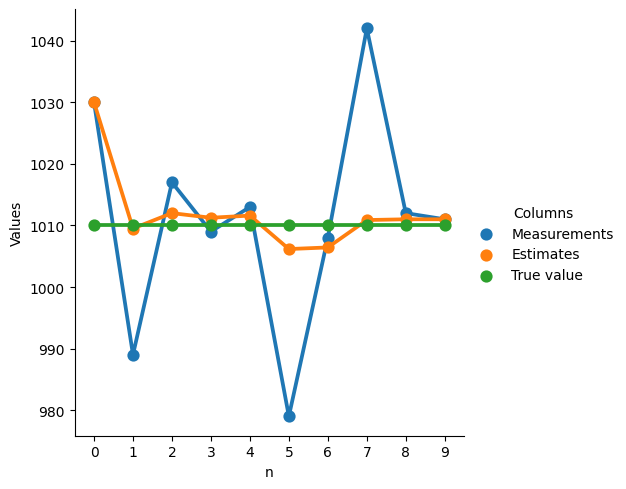

In [26]:
import pandas as pd


def factor(value_index: int) -> float:
    return 1.0 / float(value_index)


def current_estimate(
    predicted_value: float, value_index: int, measurement: float
) -> float:
    return predicted_value + (factor(value_index) * (measurement - predicted_value))


initial_guess = 1000
measurements = np.array([1030, 989, 1017, 1009, 1013, 979, 1008, 1042, 1012, 1011])
# oblicz pierwszą estymatę
estimates = np.array([current_estimate(initial_guess, 1, measurements[0])])
# oblicz resztę
for n in range(1, len(measurements)):
    estimates = np.append(
        estimates, current_estimate(estimates[n - 1], n + 1, measurements[n])
    )

# stwórz ramkę danych do wizualizacji

df = pd.DataFrame(
    {
        "n": list(range(len(measurements))),
        "Measurements": measurements,
        "Estimates": estimates,
        "True value": [1010] * len(measurements),
    }
)

sns_df = df.melt("n", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="n", y="Values", hue="Columns", kind="point")


Możemy zauważyć że nasz algorytm dość precyzyjnie estymował prawdziwą wartość wagi sztabki złota, która wynosi 1010g. Widzimy również że im więcej pomiarów zostało wykonanych, tym mniejszy wpływ mają na estymowaną wartość.

### Przykład 2 - śledzenie trasy samolotu lecącego ze stałą prędkością (filtr alfa-beta)


## Jednowymiarowy filtr Kalmana

